In [58]:
!date

Wed Feb 12 21:52:57 JST 2020


In [59]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [60]:
stansimsdir="stan-sims-probable"
dirs = !ls -d {stansimsdir}/*
dirs

['stan-sims-probable/gamma-no_truncation',
 'stan-sims-probable/gamma-truncated',
 'stan-sims-probable/lognormal-no_truncation',
 'stan-sims-probable/lognormal-truncated',
 'stan-sims-probable/weibull-no_truncation']

In [83]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])[[1,2,0]]
distribs

array(['lognormal', 'weibull', 'gamma'], dtype='<U9')

In [84]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation', 'truncated'], dtype='<U13')

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.577,0.512,3.636,5.617,0.002,0.001,101126.0,94730.0,110573.0,70748.0,1.0
sd_SI,2.762,0.645,1.698,4.049,0.002,0.002,85256.0,74320.0,107152.0,68077.0,1.0
param1,1.359,0.108,1.143,1.568,0.000,0.000,115256.0,115207.0,115583.0,86325.0,1.0
param2,0.552,0.079,0.412,0.712,0.000,0.000,99011.0,93308.0,107069.0,79015.0,1.0


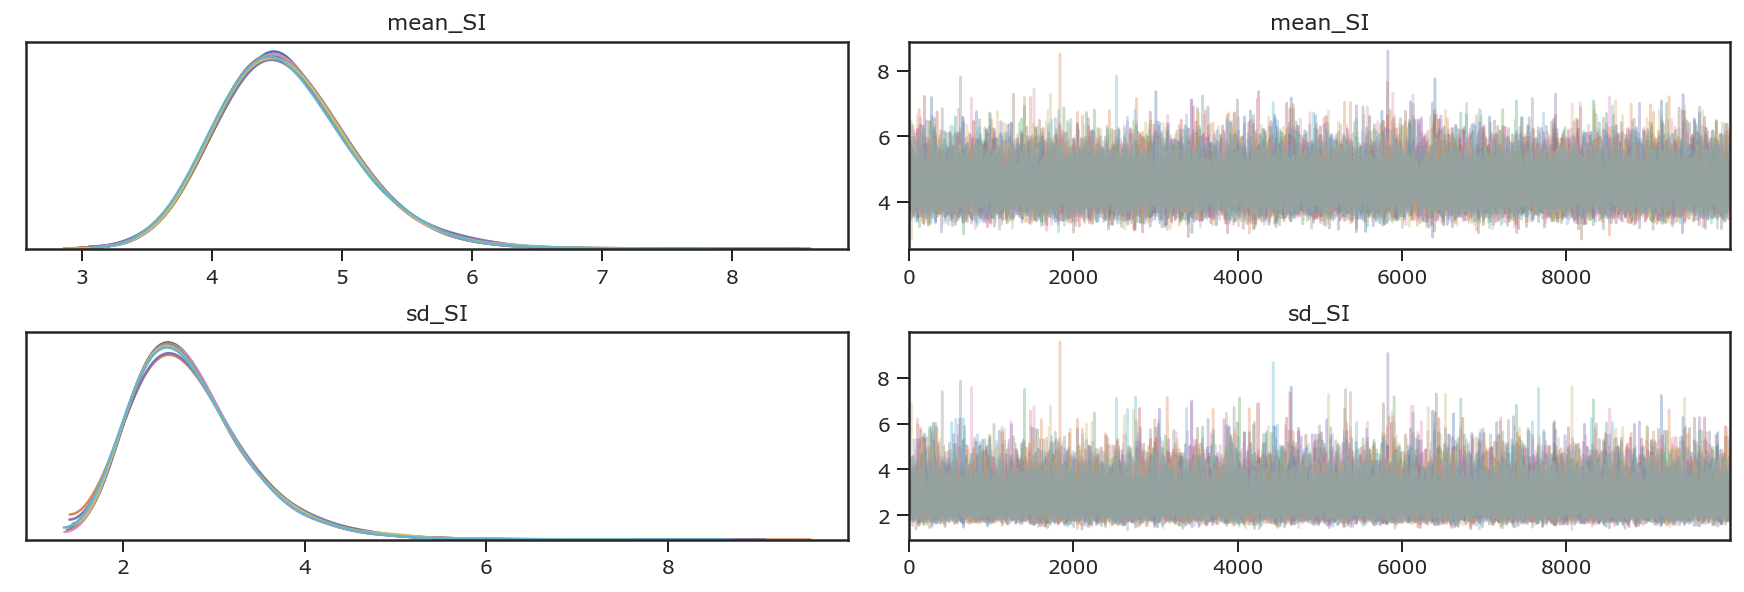

In [92]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.779,0.530,3.793,5.849,0.002,0.001,116518.0,109222.0,125366.0,74959.0,1.0
sd_SI,2.697,0.505,1.839,3.720,0.002,0.001,102271.0,90248.0,122909.0,71835.0,1.0
param1,3.331,0.918,1.667,5.146,0.003,0.002,125530.0,124151.0,120142.0,82145.0,1.0
param2,0.706,0.209,0.334,1.130,0.001,0.000,127894.0,127894.0,119706.0,79039.0,1.0


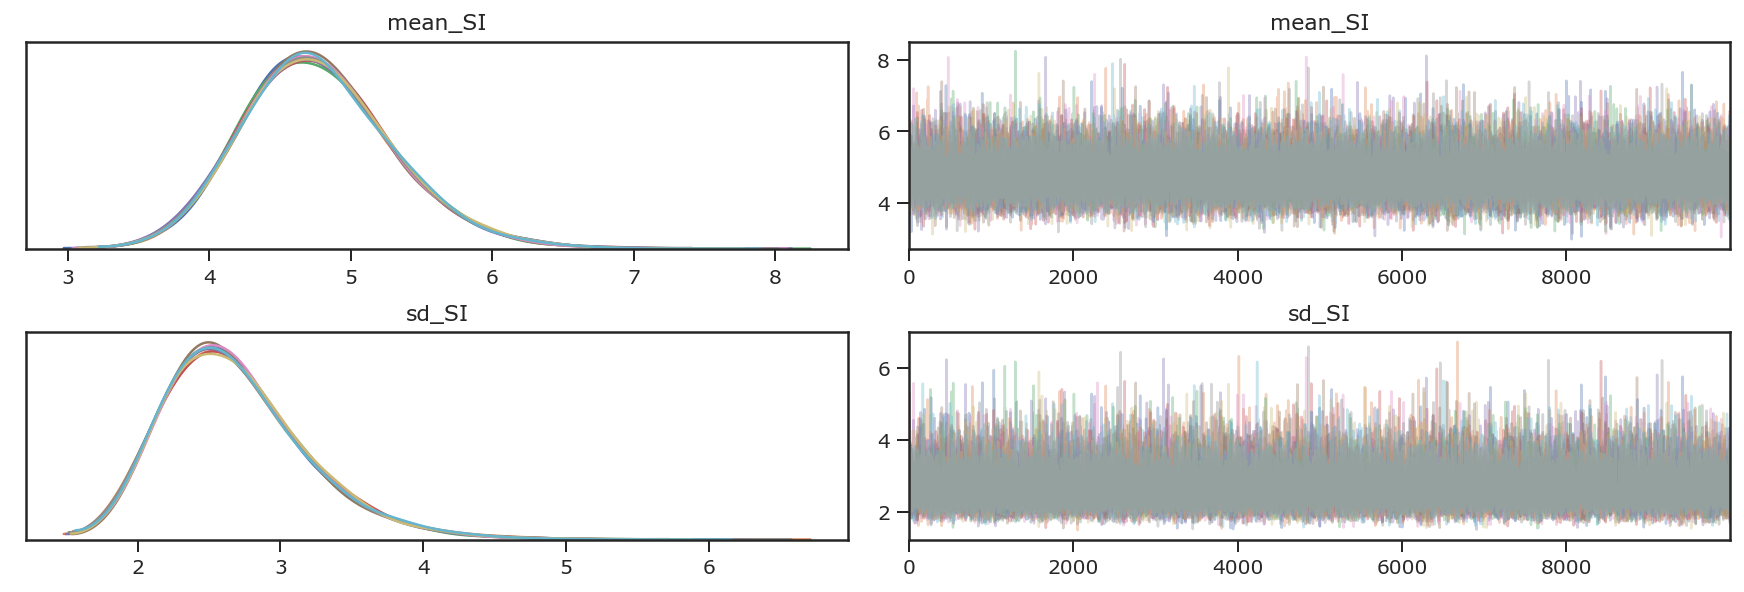

In [93]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.793,0.507,3.816,5.788,0.001,0.001,167974.0,156859.0,174491.0,75447.0,1.0
sd_SI,2.608,0.423,1.893,3.436,0.001,0.001,120711.0,99574.0,175305.0,68029.0,1.0
param1,1.950,0.293,1.381,2.526,0.001,0.000,176803.0,174412.0,173410.0,77761.0,1.0
param2,5.386,0.575,4.275,6.518,0.001,0.001,172538.0,163558.0,176168.0,77146.0,1.0


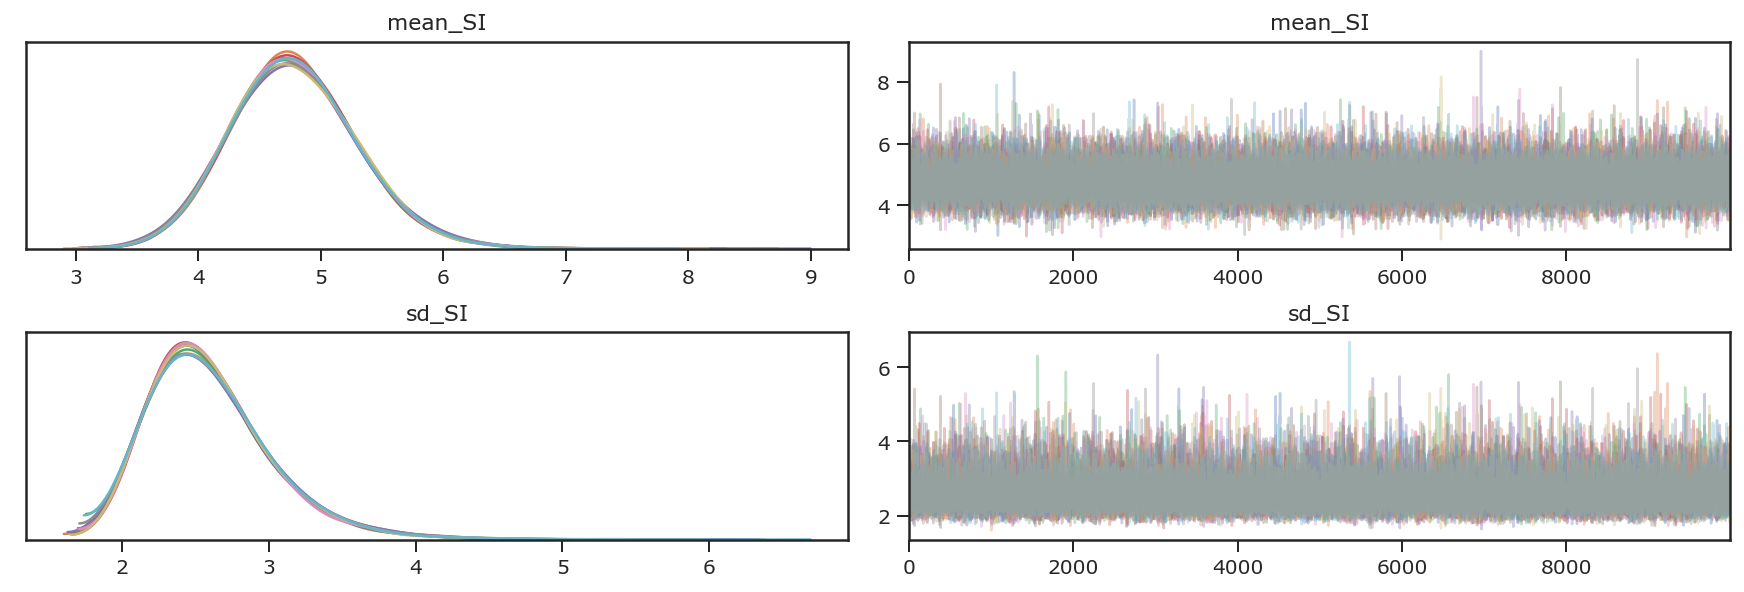

In [94]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

## Comparing different models

In [95]:
!mkdir -p ../../results/Andrei/Stan-sims-probable/traceplots
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))

        posterior_glob = !ls {stansimsdir}/{folder}/trace-*

        cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        cmdstan_stats = get_stats(cmdstan_data)  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims-probable/summary-'+truncation_type+'.xlsx')

lognormal-no_truncation
['lognormal', 'no_truncation', '4.6 (3.7, 5.7)', '2.8 (1.8, 4.3)', '1.6 (1.0, 2.1)', '3.9 (3.1, 4.8)', '9.5 (7.4, 13.5)', '13.8 (10.1, 21.5)']
weibull-no_truncation
['weibull', 'no_truncation', '4.8 (3.9, 5.9)', '2.6 (2.0, 3.6)', '1.2 (0.6, 1.9)', '4.4 (3.5, 5.5)', '9.4 (7.8, 12.4)', '11.7 (9.4, 16.4)']
gamma-no_truncation
['gamma', 'no_truncation', '4.8 (3.9, 5.9)', '2.7 (1.9, 3.9)', '1.4 (0.7, 2.0)', '4.2 (3.4, 5.3)', '9.7 (7.7, 13.2)', '12.9 (9.9, 18.3)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,lognormal,128.0,0.00,0.945,no_truncation,"4.6 (3.7, 5.7)","2.8 (1.8, 4.3)","1.6 (1.0, 2.1)","3.9 (3.1, 4.8)","9.5 (7.4, 13.5)","13.8 (10.1, 21.5)"
1,gamma,129.1,1.10,0.027,no_truncation,"4.8 (3.9, 5.9)","2.7 (1.9, 3.9)","1.4 (0.7, 2.0)","4.2 (3.4, 5.3)","9.7 (7.7, 13.2)","12.9 (9.9, 18.3)"
2,weibull,130.4,2.45,0.027,no_truncation,"4.8 (3.9, 5.9)","2.6 (2.0, 3.6)","1.2 (0.6, 1.9)","4.4 (3.5, 5.5)","9.4 (7.8, 12.4)","11.7 (9.4, 16.4)"


# With truncation

lognormal-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.699,0.587,3.624,5.856,0.002,0.001,92390.0,80980.0,114258.0,63415.0,1.0
sd_SI,2.936,0.802,1.717,4.500,0.003,0.002,73008.0,57288.0,107746.0,61234.0,1.0
param1,1.376,0.113,1.151,1.597,0.000,0.000,114212.0,113142.0,114819.0,83222.0,1.0
param2,0.567,0.086,0.409,0.735,0.000,0.000,88959.0,82065.0,99804.0,73233.0,1.0


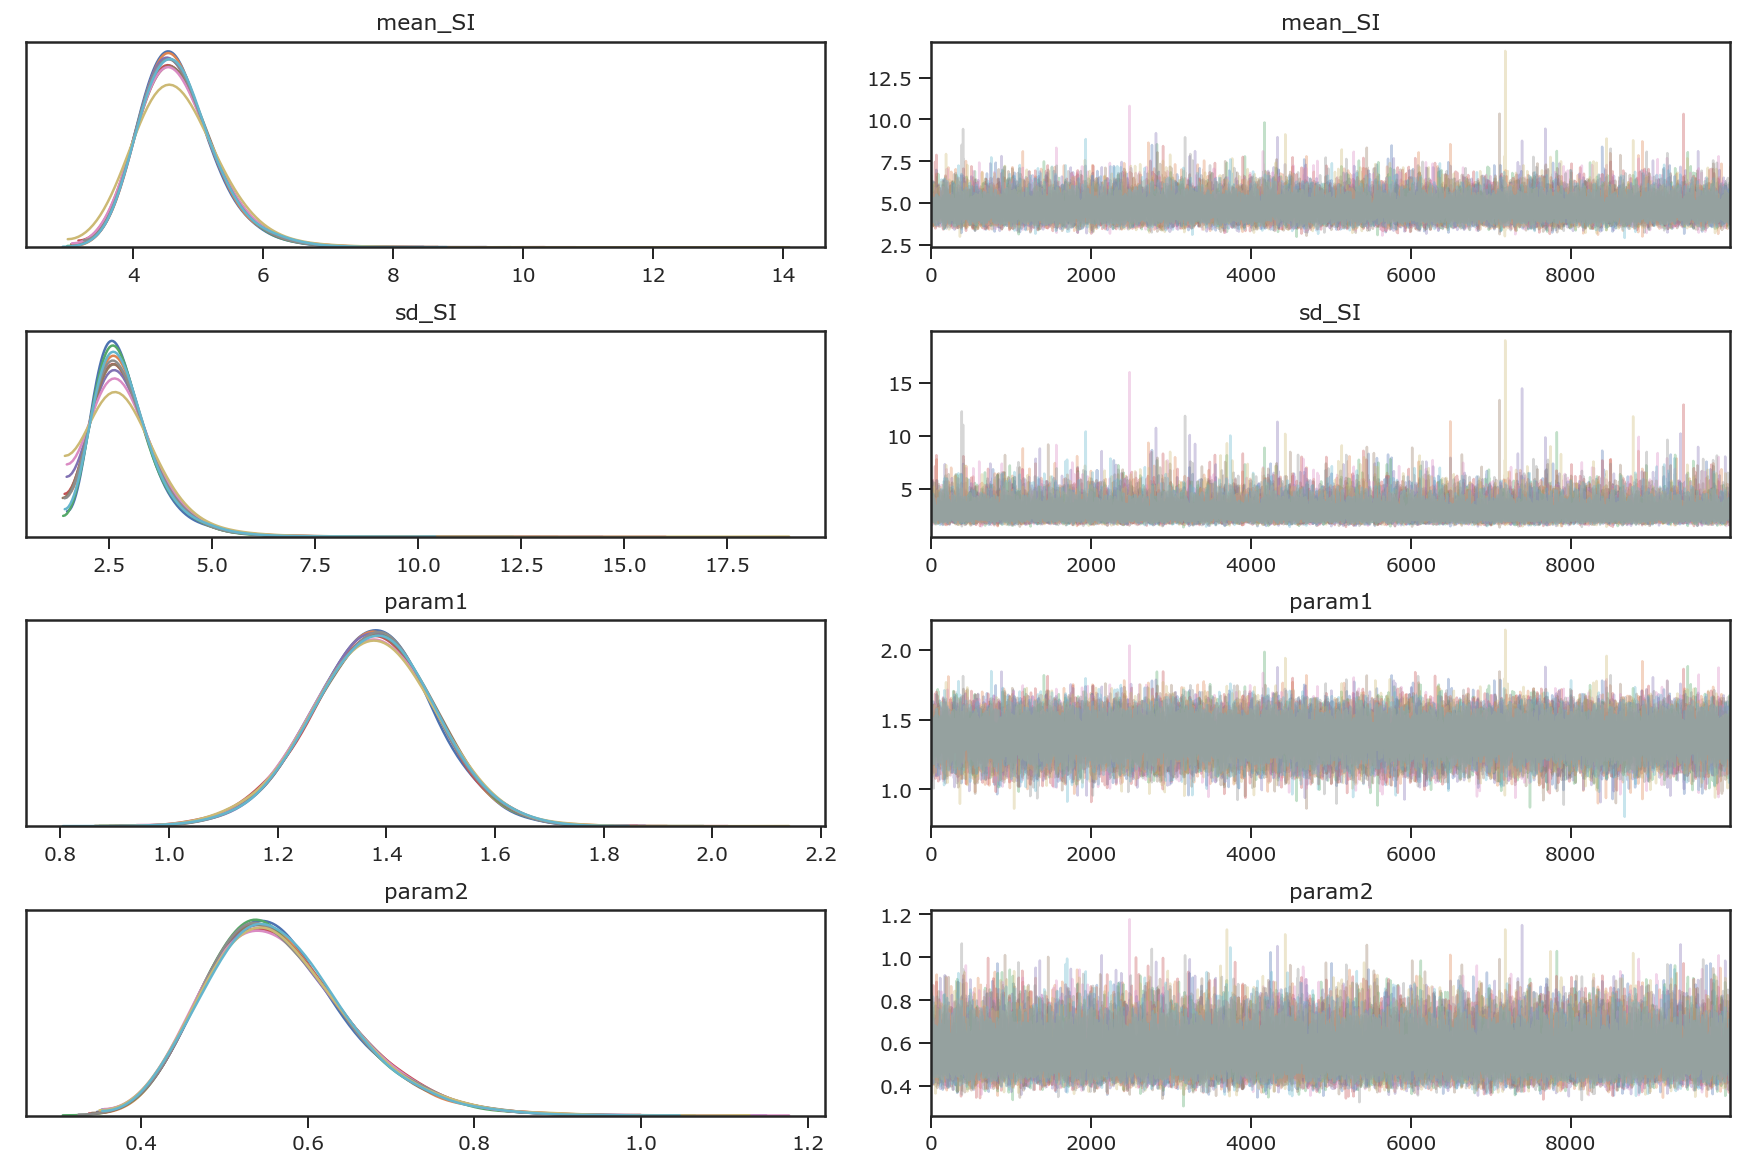

In [225]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI', 'param1', 'param2']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.841,0.594,3.729,6.002,0.002,0.001,90854.0,79677.0,110837.0,62480.0,1.0
sd_SI,2.742,0.616,1.753,3.939,0.002,0.002,70229.0,55516.0,100811.0,57644.0,1.0
param1,3.367,1.031,1.514,5.426,0.003,0.002,108904.0,108904.0,101021.0,73245.0,1.0
param2,0.707,0.235,0.290,1.181,0.001,0.001,108954.0,108954.0,97887.0,65911.0,1.0


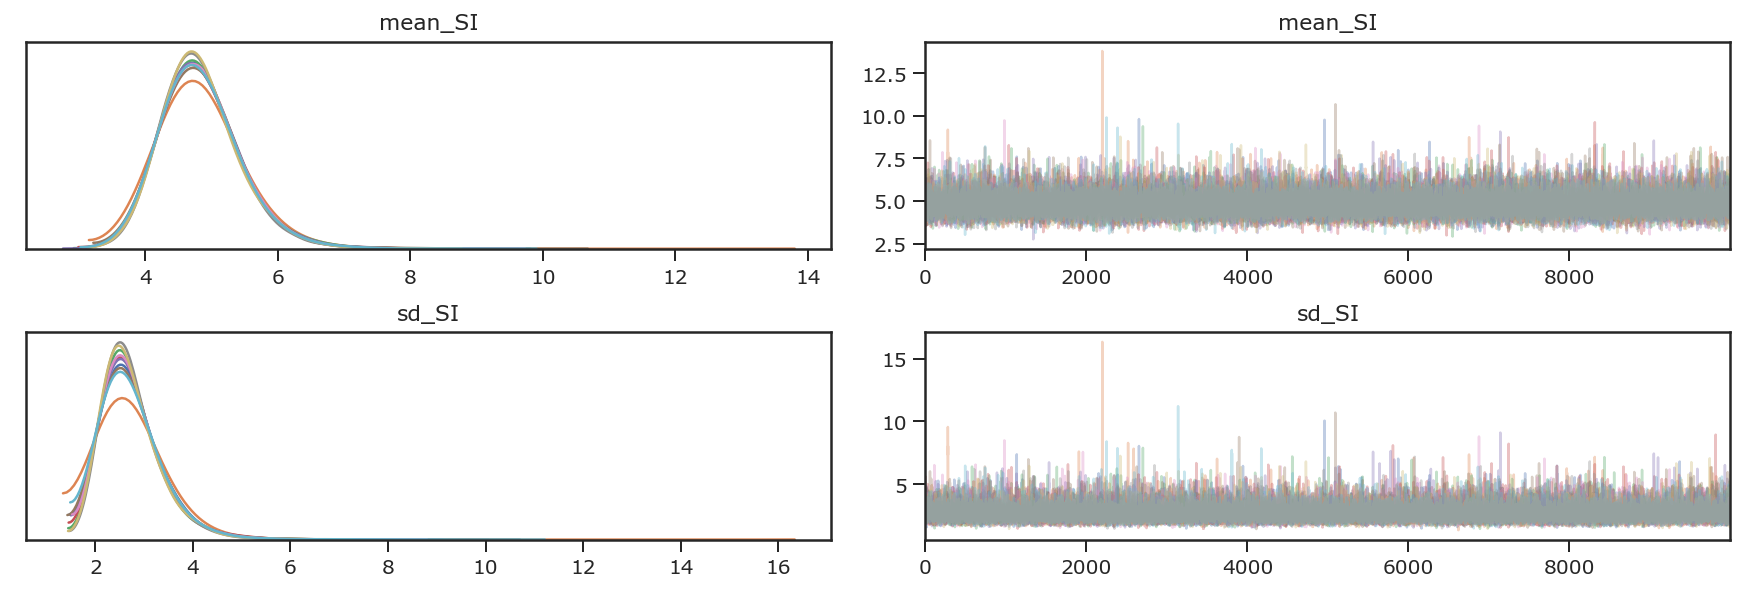

In [54]:
folder = "gamma-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

weibull-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.876,0.563,3.813,5.958,0.002,0.001,113249.0,93968.0,140871.0,63132.0,1.0
sd_SI,2.686,0.515,1.899,3.653,0.002,0.002,72640.0,53418.0,136611.0,58121.0,1.0
param1,1.931,0.299,1.357,2.527,0.001,0.001,142339.0,142339.0,138167.0,71978.0,1.0
param2,5.475,0.629,4.276,6.696,0.002,0.001,125164.0,107686.0,145017.0,65708.0,1.0


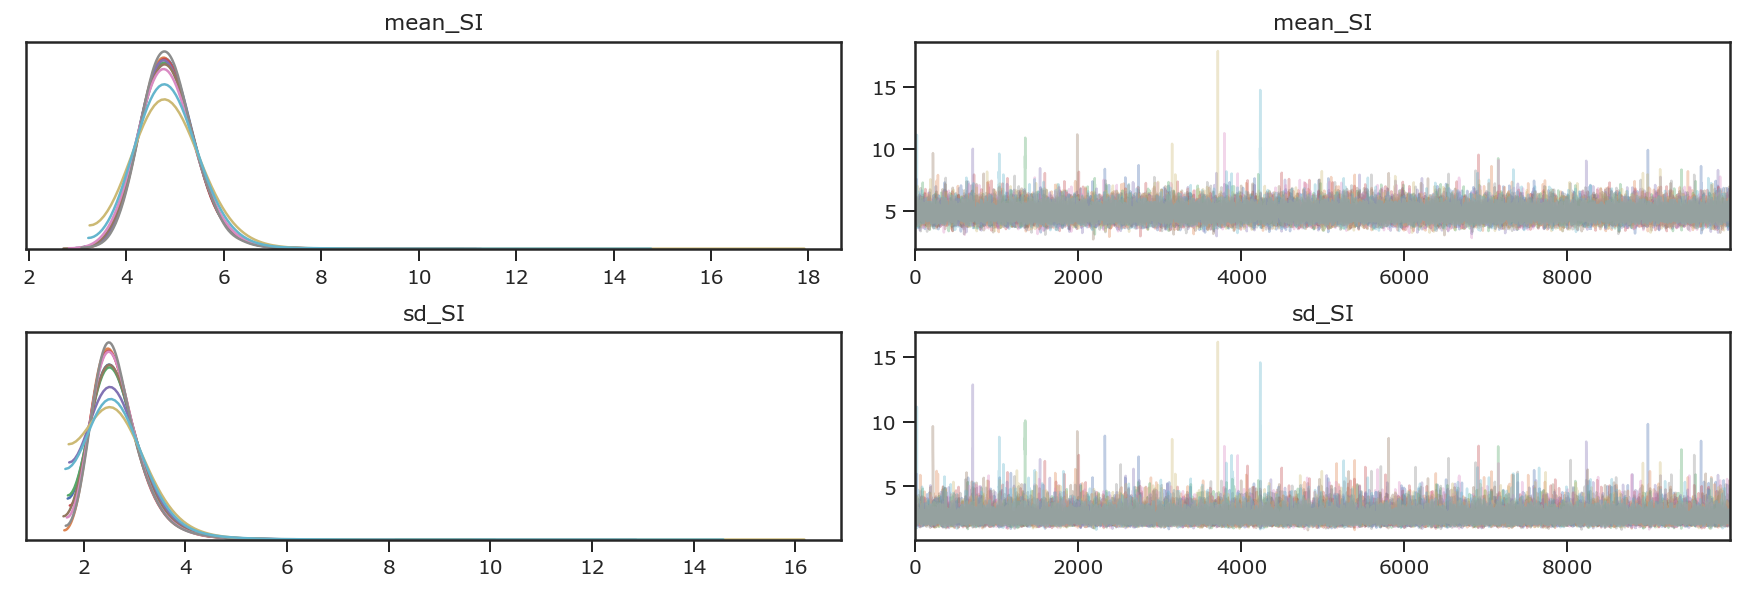

In [96]:
folder = "weibull-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

lognormal-truncated
['lognormal', 'truncated', '4.7 (3.7, 6.0)', '2.9 (1.9, 4.9)', '1.6 (1.0, 2.1)', '4.0 (3.1, 4.9)', '9.8 (7.5, 14.8)', '14.4 (10.2, 24.4)']
weibull-truncated
['weibull', 'truncated', '4.9 (3.9, 6.1)', '2.7 (2.0, 3.9)', '1.2 (0.6, 1.9)', '4.5 (3.5, 5.6)', '9.6 (7.9, 13.3)', '12.0 (9.6, 17.9)']
gamma-truncated
['gamma', 'truncated', '4.9 (3.9, 6.3)', '2.8 (2.0, 4.3)', '1.4 (0.7, 2.1)', '4.3 (3.4, 5.5)', '10.0 (7.8, 14.7)', '13.2 (10.0, 20.7)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,lognormal,224.0,0.00,1.0,truncated,"4.7 (3.7, 6.0)","2.9 (1.9, 4.9)","1.6 (1.0, 2.1)","4.0 (3.1, 4.9)","9.8 (7.5, 14.8)","14.4 (10.2, 24.4)"
1,gamma,225.4,1.39,0.0,truncated,"4.9 (3.9, 6.3)","2.8 (2.0, 4.3)","1.4 (0.7, 2.1)","4.3 (3.4, 5.5)","10.0 (7.8, 14.7)","13.2 (10.0, 20.7)"
2,weibull,226.8,2.77,0.0,truncated,"4.9 (3.9, 6.1)","2.7 (2.0, 3.9)","1.2 (0.6, 1.9)","4.5 (3.5, 5.6)","9.6 (7.9, 13.3)","12.0 (9.6, 17.9)"


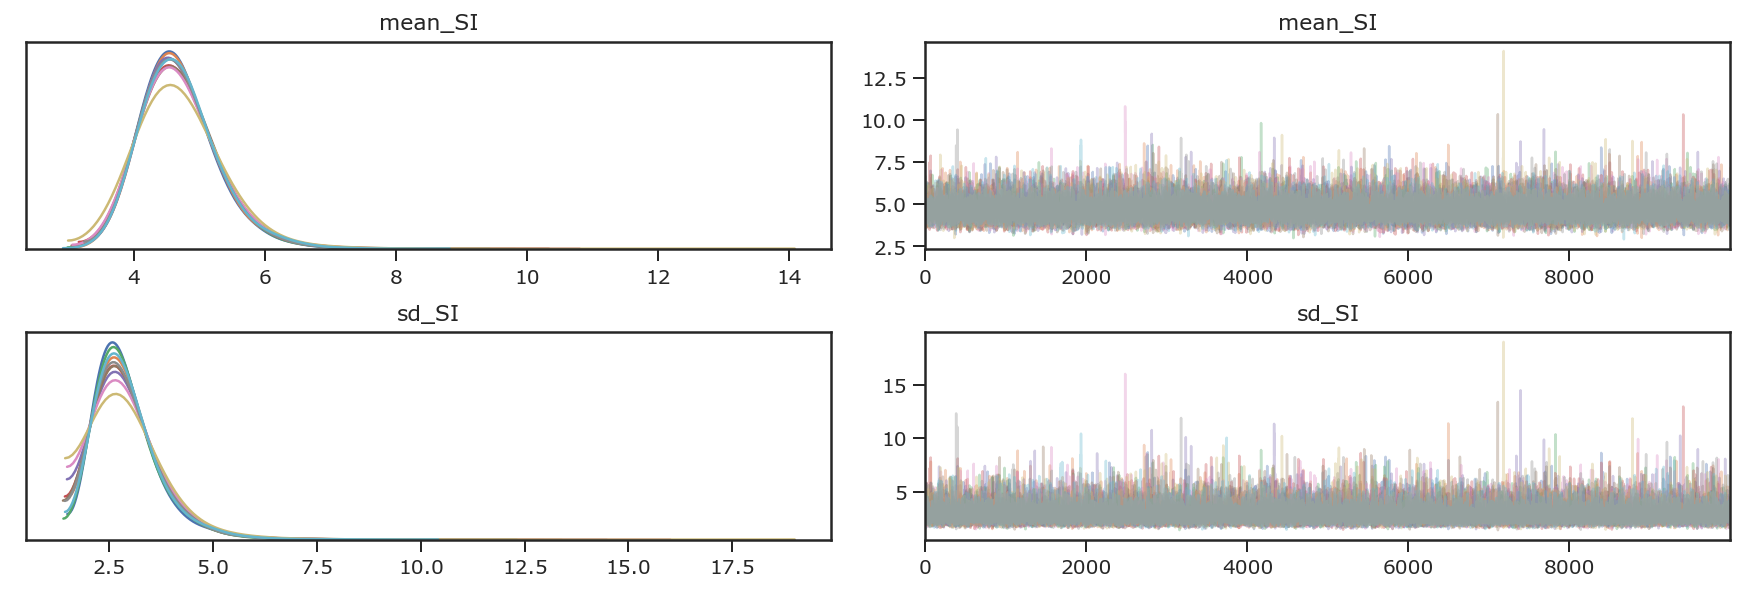

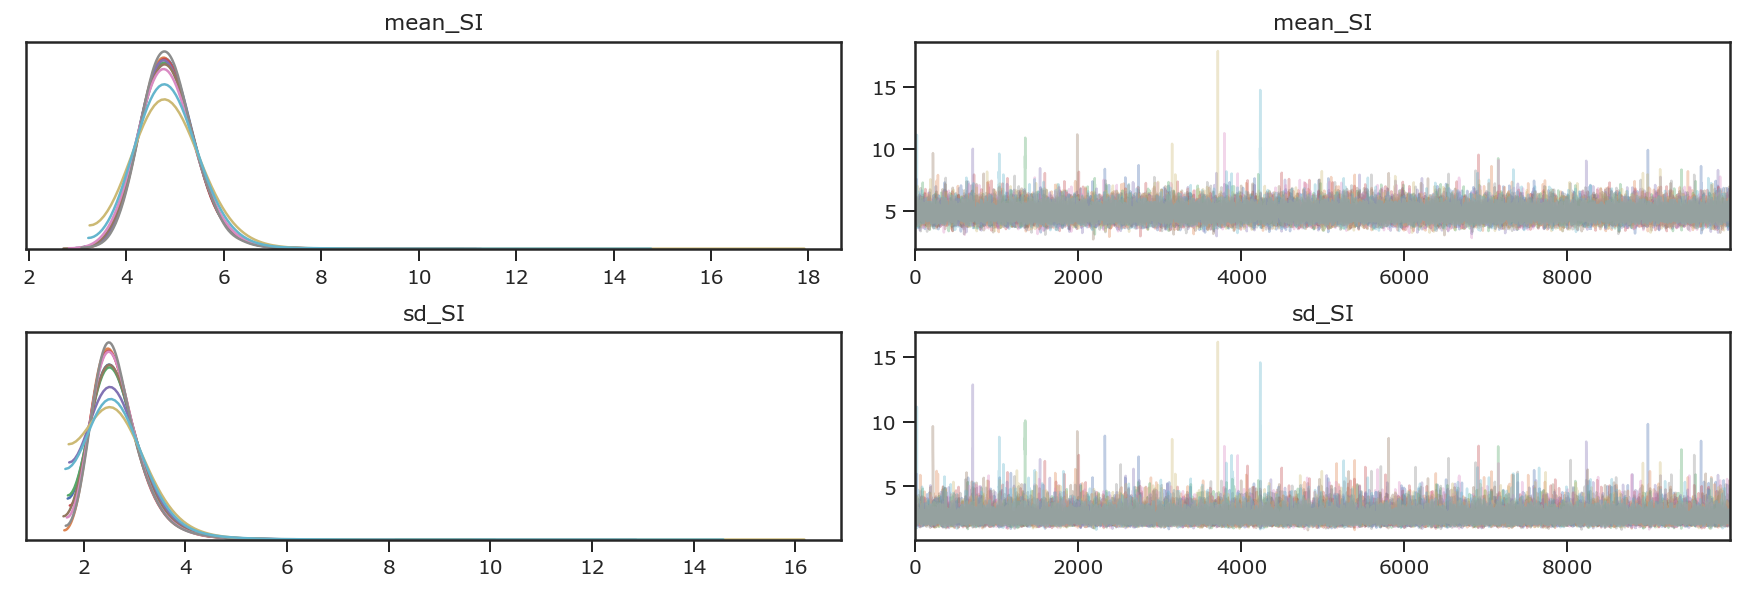

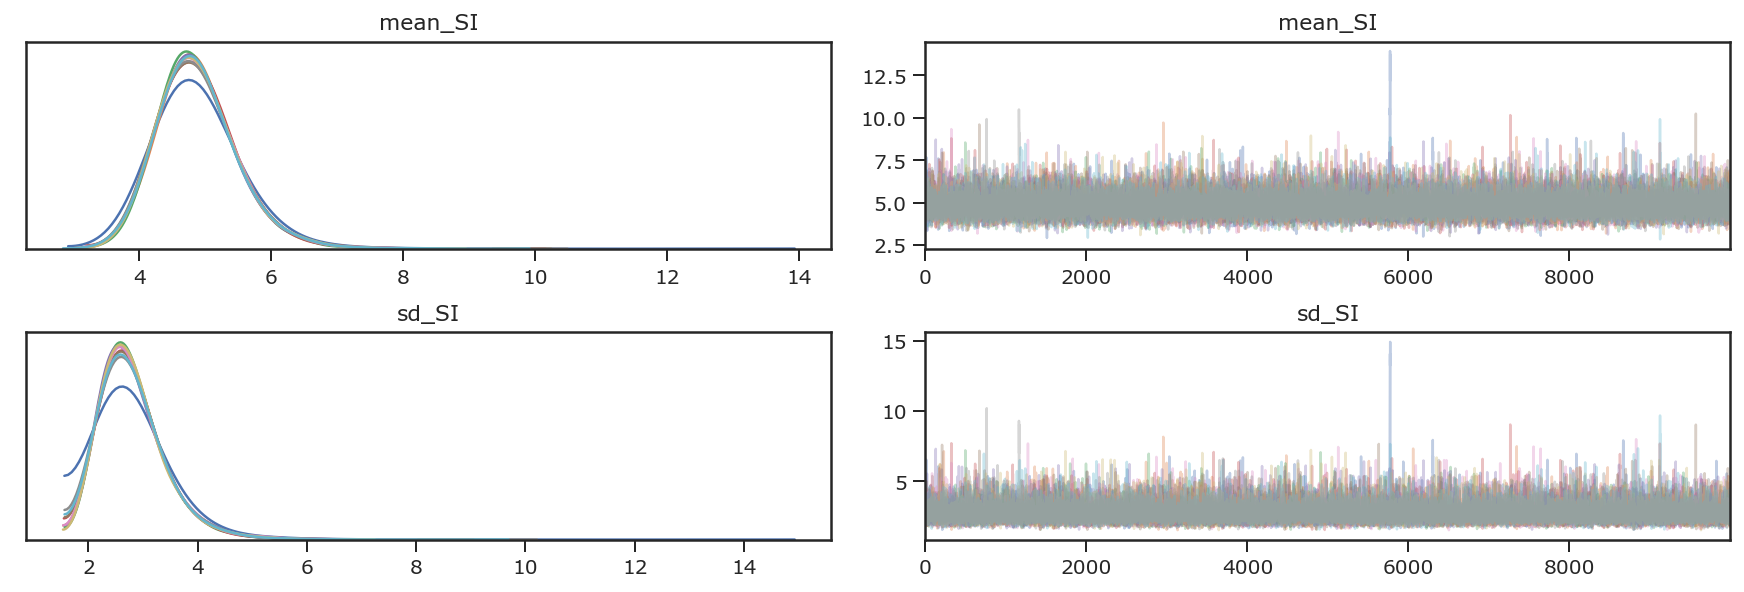

In [98]:
!mkdir -p ../../results/Andrei/Stan-sims-probable/traceplots
for truncation_type in ['truncated']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))

        posterior_glob = !ls {stansimsdir}/{folder}/trace-*

        cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        cmdstan_stats = get_stats(cmdstan_data)  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

        az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
        plt.savefig("../../results/Andrei/Stan-sims-probable/traceplots/trace-"+folder+".pdf", format='pdf')

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims-probable/summary-'+truncation_type+'.xlsx')

# Preparing the figure

In [267]:
from scipy.optimize import fsolve
import scipy.special as sps


def find_params_Weibull(p,mu,SD):
    θ, k = np.exp(p)
    return (θ*sps.gamma(1+1/k)-mu, θ*np.sqrt(sps.gamma(1+2/k)-sps.gamma(1+1/k)**2)-SD)

def weibull_pdf(x,θ,k):
    return (k / θ) * (x / θ)**(k - 1) * np.exp(-(x / θ)**k)

weibull_cdf = lambda x,θ,k: -np.expm1(-(x/θ)**k)

mean_SARS = 8.4
sd_SARS = 3.8

In [284]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()

xstep = .1
xmax = 20
ymax = 0.12
x = np.arange(.01,xmax+xstep,xstep)

nsamples = 10000
lognormpdf = lambda x, mu, sigma: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*ss.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
yy = np.stack([[lognormcdf(xx+xstep,param1[idx],param2[idx])-lognormcdf(xx,param1[idx],param2[idx]) for xx in x] for idx in range(nsamples)]).T

lognormal-truncated


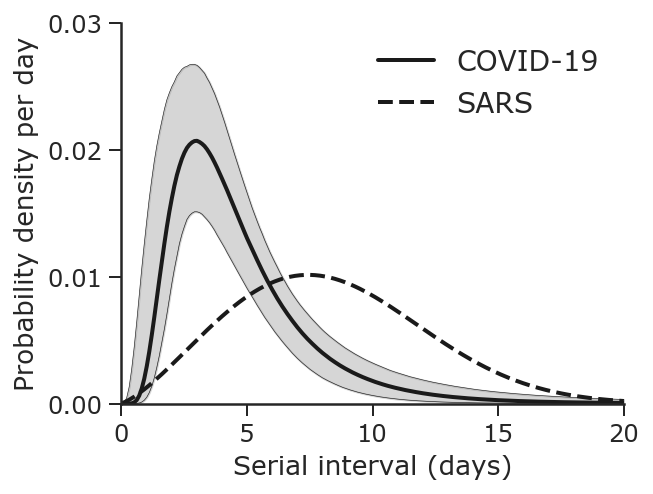

In [287]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

disease = 'COVID-19'
Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=2, color=clrs[0], label=disease)
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.35)

ax.set_xlabel('Serial interval (days)'); ax.set_ylabel('Probability density per day')

disease = 'SARS'
res = fsolve(lambda x: find_params_Weibull(x, mean_SARS, sd_SARS), (1,1))
res_ = np.exp(res)
Y_SARS = [weibull_cdf(xx+xstep, res_[0], res_[1])-weibull_cdf(xx, res_[0], res_[1]) for xx in x]
ax.plot(x, Y_SARS, label=disease, lw=2, color=clrs[0], ls='dashed')

ax.legend(frameon=False)

ax.set_ylim(bottom=0, top=.03)
ax.set_xlim(0, 20)
ytks = [0,.01,.02,.03]; ax.set_yticks(ytks); 
ax.spines['left'].set_bounds(0,.03)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

my_dpi = 300
plt.savefig("../../results/Fig-MAIN.pdf",
            format='pdf',
            figsize=(3.54331/my_dpi, 3.5/my_dpi), dpi=my_dpi,
            bbox_inches='tight');